In [1]:
# 参数初始化
dim = (176,208)           
zoom = [.99,1.01]            
bright_range = [.8,1.2]                                

In [3]:
train_root = r'D:\Program Files (x86)\pythonProject\python_file\南洋理工\Alzheimer_s Dataset\train'
test_root = r'D:\Program Files (x86)\pythonProject\python_file\南洋理工\Alzheimer_s Dataset\test'

In [4]:
from skimage import io
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sn
from tensorflow.keras import backend as K
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Flatten, Dropout, Activation, Conv2D, MaxPooling2D, LeakyReLU,BatchNormalization,GlobalAveragePooling2D
from tensorflow.keras.callbacks import TensorBoard
import pickle
from PIL import Image
import time
import os
from PIL import Image
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split
from keras import regularizers

In [6]:

def data_loader_5000(train_root,test_root):
    
    #设置参数进行数据生成
    zoom = [.99,1.01]             
    bright_range = [.8,1.2]                               
    momentum = .9   
    
    train_dr = ImageDataGenerator(rescale=1./255,fill_mode='constant',cval=0,
                                                               brightness_range=bright_range,zoom_range=zoom,
                                                               data_format='channels_last',zca_whitening=False)

    train_data_gen = train_dr.flow_from_directory(directory=train_root,target_size=dim,
                                                  batch_size=5000)

    test_dr = ImageDataGenerator(rescale=1./255,fill_mode='constant',cval=0,zoom_range=[1,1],
                                                              data_format='channels_last') 

    test_data_gen = test_dr.flow_from_directory(directory=test_root,target_size=dim,batch_size=5000,
                                               shuffle = False) 

    # 设置参数切分数据集
    test_split_percent = .2       
    validation_split_percent = .2 

    train_data,train_labels =  train_data_gen.next()
    test_data,test_labels = test_data_gen.next()
    total_data = np.concatenate((train_data,test_data))
    total_labels = np.concatenate((train_labels,test_labels))

    initial_split = test_split_percent+validation_split_percent
    test_val_split = test_split_percent/initial_split

    train_data, test_val_data, train_labels, test_val_labels = train_test_split(total_data,total_labels,
                                                                                test_size=initial_split)

    test_data, val_data, test_labels, val_labels = train_test_split(test_val_data,test_val_labels,
                                                                    test_size=test_val_split)
    
    return  train_data ,train_labels, test_data, val_data, test_labels, val_labels


In [7]:
from sklearn.metrics import accuracy_score, average_precision_score,precision_score,f1_score,recall_score
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint,LearningRateScheduler,ReduceLROnPlateau
import math

earlyStopping = EarlyStopping(
    monitor='val_accuracy', patience=8, verbose=1, mode='max', restore_best_weights=True)

reduce = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1,
                           patience=5, verbose=1, mode='max', cooldown=1, min_lr=1e-8)

callback_list = [earlyStopping, reduce]

#设置回调函数用于后续训练

In [8]:
import random

args = 12
np.random.seed(args)

random.seed(args)              ##

# opt = tf.keras.optimizers.SGD(learning_rate=lr, momentum=momentum, nesterov=True,name='SGD') 
adam=tf.keras.optimizers.Adam(learning_rate=0.001)

In [9]:

earlyStopping = EarlyStopping(
    monitor='val_accuracy', patience=12, verbose=1, mode='max', restore_best_weights=True)

reduce = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1,
                           patience=5, verbose=1, mode='max', cooldown=1, min_lr=1e-8)
callback_list = [earlyStopping, reduce]
inputShape =(dim[0],dim[1], 3) 

In [10]:
Res_model = tf.keras.applications.resnet.ResNet50(include_top=False, 
                                                weights='imagenet', 
                                                input_shape=(dim[0],dim[1],3),
                                                   pooling="max", 
                                                   classes=4)
#     Res_model.trainable = False
Res_model.get_layer('conv2_block1_2_conv').trainable = False
Res_model.get_layer('conv2_block1_3_conv').trainable = False
#     Res_model.get_layer('conv2_block1_0_conv').trainable = True
#     Res_model.get_layer('conv2_block1_3_conv').trainable = True
#     Res_model.get_layer('conv2_block2_1_conv').trainable = False
Res_model.get_layer('conv2_block2_3_conv').trainable = False

Res_model.get_layer('conv3_block3_2_conv').trainable = False
Res_model.get_layer('conv3_block3_3_conv').trainable = False

#     Res_model.get_layer('conv3_block4_1_conv').trainable = False
Res_model.get_layer('conv3_block4_2_conv').trainable = False

Res_model.get_layer('conv4_block1_2_conv').trainable = False
Res_model.get_layer('conv4_block1_3_conv').trainable = False

Res_model.get_layer('conv4_block2_2_conv').trainable = False
Res_model.get_layer('conv4_block2_3_conv').trainable = False

Res_model.get_layer('conv4_block3_2_conv').trainable = False
Res_model.get_layer('conv4_block3_3_conv').trainable = False

Res_model.get_layer('conv4_block4_2_conv').trainable = False
Res_model.get_layer('conv4_block4_3_conv').trainable = False

Res_model.get_layer('conv4_block5_2_conv').trainable = False
Res_model.get_layer('conv4_block5_3_conv').trainable = False

Res_model.get_layer('conv5_block3_2_conv').trainable = False
Res_model.get_layer('conv5_block3_3_conv').trainable = False
#     Res_model.get_layer('conv4_block6_2_conv').trainable = False
#     Res_model.get_layer('conv4_block6_3_conv').trainable = False


Res_model.summary()
    



model=Sequential()
model.add(Res_model)
# model.add(Flatten())

model.add(Dense(1024,
                kernel_regularizer=regularizers.l2(0.0001),
                kernel_initializer='he_uniform')
          )
model.add(BatchNormalization())
model.add(Activation('relu'))
#     model.add(Dropout(0.25) )
model.add(Dropout(0.3) )

model.add(Dense(4,activation='softmax') )
model.summary()




Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 176, 208, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 182, 214, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 88, 104, 64)  9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 88, 104, 64)  256         ['conv1_conv[0][0]']      

 conv2_block3_2_conv (Conv2D)   (None, 44, 52, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 44, 52, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 44, 52, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_3_conv (Conv2D)   (None, 44, 52, 256)  16640       ['conv2_block3_2_relu[0][0]']    
                                                                                                  
 conv2_blo

 conv3_block3_2_conv (Conv2D)   (None, 22, 26, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 22, 26, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 22, 26, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_3_conv (Conv2D)   (None, 22, 26, 512)  66048       ['conv3_block3_2_relu[0][0]']    
                                                                                                  
 conv3_blo

 conv4_block2_1_relu (Activatio  (None, 11, 13, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 11, 13, 256)  590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 11, 13, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_2_relu (Activatio  (None, 11, 13, 256)  0          ['conv4_block2_2_bn[0][0]']      
 n)                                                                                               
          

                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 11, 13, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 11, 13, 256)  590080      ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_block5_2_bn (BatchNormal  (None, 11, 13, 256)  1024       ['conv4_block5_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_2_relu (Activatio  (None, 11, 13, 256)  0          ['conv4_block5_2_bn[0][0]']      
 n)       

 conv5_block2_1_conv (Conv2D)   (None, 6, 7, 512)    1049088     ['conv5_block1_out[0][0]']       
                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 6, 7, 512)   2048        ['conv5_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_1_relu (Activatio  (None, 6, 7, 512)   0           ['conv5_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block2_2_conv (Conv2D)   (None, 6, 7, 512)    2359808     ['conv5_block2_1_relu[0][0]']    
                                                                                                  
 conv5_blo

In [11]:

model.compile(optimizer=adam, loss=tf.keras.losses.categorical_crossentropy, metrics=['accuracy'])


In [12]:
#生成数据
train_data ,train_labels, test_data, val_data, test_labels, val_labels = data_loader_5000(train_root , test_root)

Found 10130 images belonging to 4 classes.
Found 1279 images belonging to 4 classes.


In [13]:
def get_result(model_history,vg_model,test_data, test_labels):
    
    #首先直观计算准确率
    test_scores = vg_model.evaluate(test_data, test_labels)
    print('Test Accuracy: %.4f%%'%(test_scores[1]*100))
    
    # 进行训练过程可视化
    fig, ax = plt.subplots(1, 2, figsize = (30, 5))
    ax = ax.ravel()

    for i, metric in enumerate(["accuracy", "loss"]):
        ax[i].plot(model_history.history[metric])
        ax[i].plot(model_history.history["val_" + metric])
        ax[i].set_title("Model {}".format(metric))
        ax[i].set_xlabel("Epochs")
        ax[i].set_ylabel(metric)
        ax[i].legend(["train", "val"])
        
    # 计算混淆矩阵，进行训练结果可视化
    pred = vg_model.predict(test_data)
    pred=np.argmax(pred,axis=1)
    cm = confusion_matrix(y_true= test_labels.argmax(axis=1),y_pred=pred,labels=[0,1,2,3])
    
    plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
    ax = sn.heatmap(cm, cmap='Blues', annot=True, fmt='d', xticklabels= ['Mild', 'Moderate', 'Normal', 'VeryMild'],
            yticklabels=['Mild', 'Moderate', 'Normal', 'VeryMild'])
    plt.title('Alzheimer\'s disease classification')
    plt.xlabel('Prediction')
    plt.ylabel('Truth')
    # plt.subplots(figsize=(9, 6))
    plt.show(ax)
    print('------Weighted-average Evaluation indicators------')
    print('Weighted precision', precision_score(test_labels.argmax(axis=1), pred, average='weighted'))
    print('Weighted recall', recall_score(test_labels.argmax(axis=1), pred, average='weighted'))
    print('Weighted f1-score', f1_score(test_labels.argmax(axis=1), pred, average='weighted'))
    print('------Macro-average Evaluation indicators------')
    print('Macro precision', precision_score(test_labels.argmax(axis=1), pred, average='macro'))
    print('Macro recall', recall_score(test_labels.argmax(axis=1), pred, average='macro'))
    print('Macro f1-score', f1_score(test_labels.argmax(axis=1), pred, average='macro'))
    print('------Micro-average Evaluation indicators------')
    print('Micro precision', precision_score(test_labels.argmax(axis=1), pred, average='micro'))
    print('Micro recall', recall_score(test_labels.argmax(axis=1), pred, average='micro'))
    print('Micro f1-score', f1_score(test_labels.argmax(axis=1), pred, average='micro'))

    


In [14]:
#训练模型
model_history = model.fit(train_data,train_labels,validation_data=(val_data,val_labels),
                          batch_size = 20,
                          callbacks= callback_list,
                          epochs=100, shuffle=True) 


Epoch 1/100
189/189 [==============================] - 63s 254ms/step - loss: 1.2968 - accuracy: 0.5439 - val_loss: 1.5149 - val_accuracy: 0.3455 - lr: 0.0010
Epoch 2/100
189/189 [==============================] - 51s 271ms/step - loss: 1.1331 - accuracy: 0.6214 - val_loss: 5.6899 - val_accuracy: 0.5008 - lr: 0.0010
Epoch 3/100
189/189 [==============================] - 157s 833ms/step - loss: 1.0767 - accuracy: 0.6318 - val_loss: 28.1526 - val_accuracy: 0.3424 - lr: 0.0010
Epoch 4/100
189/189 [==============================] - 182s 965ms/step - loss: 0.9437 - accuracy: 0.6830 - val_loss: 1.2641 - val_accuracy: 0.4371 - lr: 0.0010
Epoch 5/100
189/189 [==============================] - 89s 473ms/step - loss: 0.7946 - accuracy: 0.7507 - val_loss: 1.1869 - val_accuracy: 0.4570 - lr: 0.0010
Epoch 6/100
189/189 [==============================] - 80s 425ms/step - loss: 0.6184 - accuracy: 0.8166 - val_loss: 0.7648 - val_accuracy: 0.7174 - lr: 0.0010
Epoch 7/100
189/189 [======================

189/189 [==============================] - 82s 433ms/step - loss: 0.0311 - accuracy: 0.9997 - val_loss: 0.7473 - val_accuracy: 0.8646 - lr: 1.0000e-07
Epoch 48/100
189/189 [==============================] - 77s 408ms/step - loss: 0.0314 - accuracy: 0.9997 - val_loss: 0.7453 - val_accuracy: 0.8639 - lr: 1.0000e-07
Epoch 49/100
189/189 [==============================] - 83s 438ms/step - loss: 0.0321 - accuracy: 0.9997 - val_loss: 0.7458 - val_accuracy: 0.8646 - lr: 1.0000e-07
Epoch 50/100
189/189 [==============================] - 87s 459ms/step - loss: 0.0308 - accuracy: 1.0000 - val_loss: 0.7465 - val_accuracy: 0.8639 - lr: 1.0000e-07
Epoch 51/100
189/189 [==============================] - ETA: 0s - loss: 0.0322 - accuracy: 0.9997
Epoch 51: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-08.
189/189 [==============================] - 84s 447ms/step - loss: 0.0322 - accuracy: 0.9997 - val_loss: 0.7444 - val_accuracy: 0.8631 - lr: 1.0000e-07
Epoch 52/100
189/189 [=========

40/40 [==============================] - 4s 80ms/step - loss: 0.6954 - accuracy: 0.8718
Test Accuracy: 87.1815%
40/40 [==============================] - 4s 71ms/step


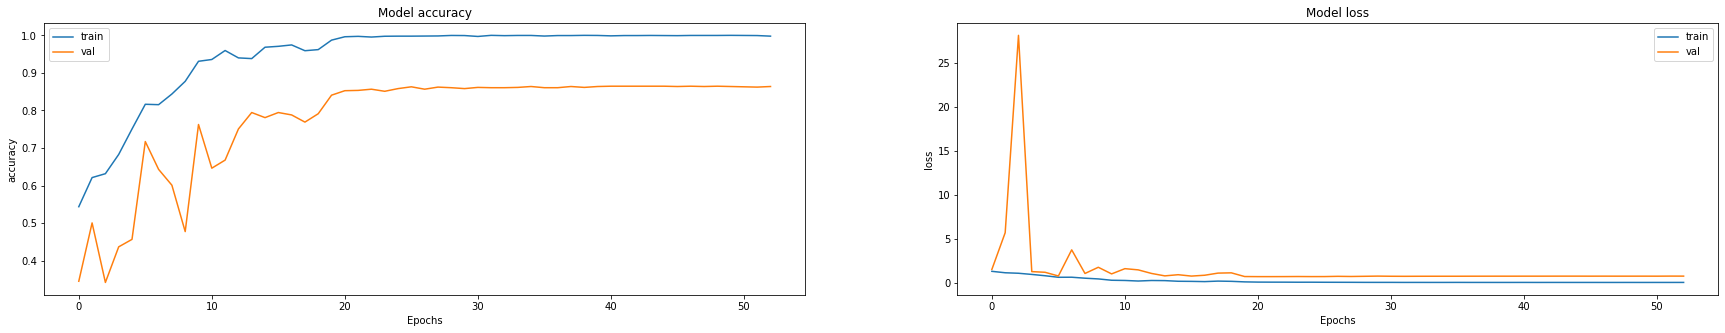

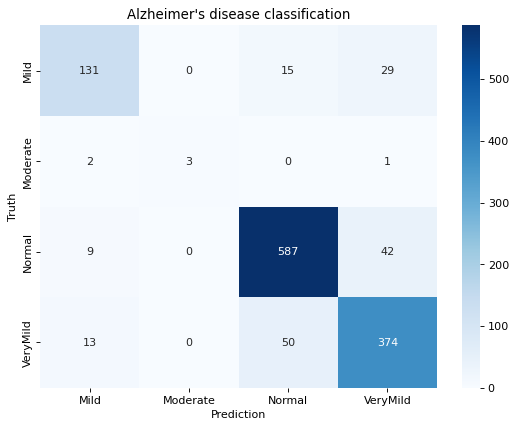

------Weighted-average Evaluation indicators------
Weighted precision 0.8716177118838616
Weighted recall 0.8718152866242038
Weighted f1-score 0.8708255149472323
------Macro-average Evaluation indicators------
Macro precision 0.8960082653025908
Macro recall 0.7561173411926984
Macro f1-score 0.80444892444155
------Micro-average Evaluation indicators------
Micro precision 0.8718152866242038
Micro recall 0.8718152866242038
Micro f1-score 0.8718152866242038


In [16]:

get_result(model_history,model,test_data,test_labels)